In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.utils import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

tar -xvzf 101_ObjectCategories.tar.gz

In [3]:
!echo "Downloading 101_Object_Categories for image notebooks"
!pip install unzip
!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip -o 101_ObjectCategories.zip
!tar -xzf /content/caltech-101/101_ObjectCategories.tar.gz
!sudo rm -rf 101_ObjectCategories.zip /content/__MACOSX /content/caltech-101
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1319 sha256=db27e2872a1971972a4b651cf7124ad99881a0191523fc636a1fa851451d0705
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76de31b718cde792c953bfd11d2414a72f204b56
Successfully built unzip
######################################################################## 100.0%
Archive:  101_ObjectCategories.zip
   creating: caltech-101/
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  
  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
101_ObjectCategories  sample_data


In [4]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/buddha', '101_ObjectCategories/car_side', '101_ObjectCategories/wheelchair', '101_ObjectCategories/stapler', '101_ObjectCategories/windsor_chair', '101_ObjectCategories/schooner', '101_ObjectCategories/saxophone', '101_ObjectCategories/headphone', '101_ObjectCategories/pagoda', '101_ObjectCategories/brain', '101_ObjectCategories/hedgehog', '101_ObjectCategories/dalmatian', '101_ObjectCategories/nautilus', '101_ObjectCategories/pigeon', '101_ObjectCategories/sunflower', '101_ObjectCategories/gerenuk', '101_ObjectCategories/gramophone', '101_ObjectCategories/crab', '101_ObjectCategories/cellphone', '101_ObjectCategories/inline_skate', '101_ObjectCategories/bass', '101_ObjectCategories/euphonium', '101_ObjectCategories/umbrella', '101_ObjectCategories/menorah', '101_ObjectCategories/joshua_tree', '101_ObjectCategories/ceiling_fan', '101_ObjectCategories/dragonfly', '101_ObjectCategories/rhino', '101_ObjectCategories/butterfly', '101_ObjectCategories/electric_guitar'

In [5]:
# helper function to load image and return it and input vector
def get_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [7]:
random.shuffle(data)

In [8]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [9]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[10, 53, 89, 91, 25, 16, 34, 86, 39, 88, 38, 39, 36, 12, 58, 69, 7, 33, 95, 1, 2, 2, 24, 90, 37, 85, 13, 49, 39, 24, 58, 47, 1, 66, 80, 67, 67, 42, 86, 69, 58, 68, 61, 3, 81, 84, 30, 17, 69, 69, 10, 90, 33, 79, 56, 83, 94, 24, 55, 83, 31, 56, 80, 29, 64, 14, 38, 28, 36, 11, 63, 9, 31, 6, 27, 67, 96, 54, 29, 1, 6, 16, 58, 32, 13, 17, 12, 67, 76, 0, 83, 20, 1, 12, 24, 30, 94, 24, 4, 14, 96, 95, 72, 88, 30, 1, 44, 15, 52, 73, 96, 10, 95, 18, 30, 30, 44, 35, 72, 21, 71, 63, 46, 58, 67, 89, 4, 39, 24, 53, 10, 72, 39, 35, 55, 69, 7, 73, 82, 34, 69, 18, 92, 66, 58, 87, 71, 83, 2, 6, 26, 35, 28, 12, 14, 38, 17, 58, 55, 0, 32, 15, 38, 73, 69, 93, 89, 28, 35, 69, 5, 4, 51, 43, 17, 94, 55, 69, 93, 38, 58, 61, 29, 51, 4, 47, 69, 30, 1, 7, 38, 68, 5, 67, 54, 22, 52, 8, 58, 3, 41, 15, 52, 79, 61, 23, 11, 14, 3, 34, 5, 81, 4, 8, 38, 69, 26, 71, 48, 57, 16, 52, 89, 0, 10, 51, 0, 31, 8, 78, 66, 80, 80, 71, 57, 61, 63, 66, 21, 22, 96, 14, 62, 30, 17, 69, 96, 15, 31, 40, 67, 55, 50, 69, 23, 15, 72, 14, 5

In [10]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [11]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


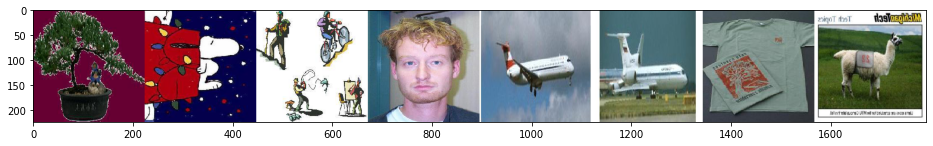

In [12]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image);

In [13]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

In [14]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
34/34 [==============================] - 275s 8s/step - loss: 4.4742 - accuracy: 0.0513 - val_loss: 4.3163 - val_accuracy: 0.0977
Epoch 2/10
34/34 [==============================] - 273s 8s/step - loss: 4.1662 - accuracy: 0.1063 - val_loss: 3.9352 - val_accuracy: 0.1880
Epoch 3/10
34/34 [==============================] - 272s 8s/step - loss: 3.7853 - accuracy: 0.1832 - val_loss: 3.5384 - val_accuracy: 0.2492
Epoch 4/10
34/34 [==============================] - 273s 8s/step - loss: 3.3463 - accuracy: 0.2536 - val_loss: 3.1427 - val_accuracy: 0.3190
Epoch 5/10
34/34 [==============================] - 272s 8s/step - loss: 2.9519 - accuracy: 0.3228 - val_loss: 2.9769 - val_accuracy: 0.3512
Epoch 6/10
34/34 [==============================] - 282s 8s/step - loss: 2.6137 - accuracy: 0.3753 - val_loss: 2.7280 - val_accuracy: 0.3845
Epoch 7/10
34/34 [==============================] - 272s 8s/step - loss: 2.2571 - accuracy: 0.4487 - val_loss: 2.6095 - val_accuracy: 0.4135
Epoch 8/10
34

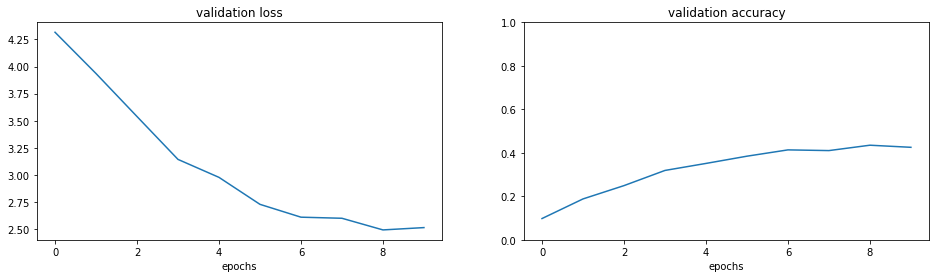

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.4448347091674805
Test accuracy: 0.45815449953079224


In [17]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [18]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [19]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
34/34 [==============================] - 2707s 80s/step - loss: 4.0534 - accuracy: 0.1684 - val_loss: 3.0498 - val_accuracy: 0.3373
Epoch 2/10
34/34 [==============================] - 2712s 80s/step - loss: 2.5638 - accuracy: 0.4317 - val_loss: 2.4005 - val_accuracy: 0.4748
Epoch 3/10
34/34 [==============================] - 2719s 80s/step - loss: 2.0025 - accuracy: 0.5497 - val_loss: 2.0698 - val_accuracy: 0.5349
Epoch 4/10
34/34 [==============================] - 2722s 80s/step - loss: 1.6671 - accuracy: 0.6192 - val_loss: 1.7131 - val_accuracy: 0.6079
Epoch 5/10
34/34 [==============================] - 2721s 80s/step - loss: 1.4304 - accuracy: 0.6721 - val_loss: 1.5651 - val_accuracy: 0.6359
Epoch 6/10
34/34 [==============================] - 2723s 81s/step - loss: 1.2942 - accuracy: 0.6995 - val_loss: 1.4558 - val_accuracy: 0.6584
Epoch 7/10
34/34 [==============================] - 2723s 81s/step - loss: 1.1434 - accuracy: 0.7368 - val_loss: 1.3941 - val_accuracy: 0.6488

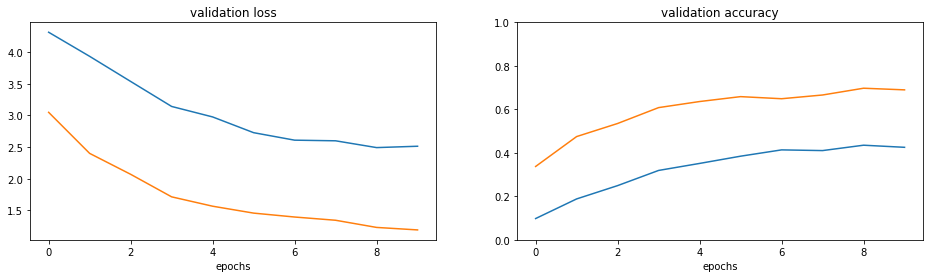

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.0616765022277832
Test accuracy: 0.7360514998435974


In [23]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])

1/1 [==============================] - 1s 804ms/step
